In [1]:
from datetime import datetime

# print date as date accessed
date_accessed = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Date accessed: {date_accessed}")

Date accessed: 2024-10-10 00:29:30


In [2]:
import xarray as xr
import dask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os, sys, glob, re, time, math, calendar

In [10]:
client.close()
cluster.close()

In [3]:
import dask
import dask.distributed as dd
if 'client' in locals():
    client.close()
    cluster.close()
cluster = dd.LocalCluster(n_workers=24, dashboard_address=8787)
client = dd.Client(cluster)

- One noticiable problem I encountered is loading all years dataset using mfdataset. 
- So, better read individual years, call velocity, and save that data into respective velocity.nc files

for year in range(2018,2025,1):
    files = sorted(glob.glob(f'data/profiler_request/{year}*'))
    ds = xr.open_mfdataset(files, combine='nested', concat_dim='time', parallel=True,).velocity
    ds.to_netcdf(f'data/{year}_velocity.nc')
    print(f'{year} done')

In [4]:
files = sorted(glob.glob(f'data/*.nc'))
ds = xr.open_mfdataset(files, combine='nested', concat_dim='time', parallel=True).velocity
data = ds.sel(range=slice(100,500))
data

<xarray.DataArray 'velocity' (station: 18, time: 341703, range: 17)> Size: 418MB
dask.array<getitem, shape=(18, 341703, 17), dtype=float32, chunksize=(17, 52704, 17), chunktype=numpy.ndarray>
Coordinates:
  * station  (station) <U9 648B 'PROF_ALB2' 'PROF_ALBA' ... 'PROF_WEBS'
  * range    (range) int64 136B 100 125 150 175 200 225 ... 400 425 450 475 500
  * time     (time) datetime64[ns] 3MB 2018-01-01T00:05:00 ... 2024-06-30T23:...
Attributes:
    units:    knots

### Checking the number of missing/non-missing values across years and locations using the average of 5th and 55th minutes as hourly data
- Also, the time instances for an hour are at 5th, 15th, 25th, 35th, 45th, and 55th minutes. They are average of 10 minutes data centered at these instances. 
- So, to get the 00 UTC data, we need to average the previous 55th and next 5th times .

In [78]:
for year in range(2018,2024,1):
    file = sorted(glob.glob(f'data/{year}_velocity.nc'))[0]
    ds = xr.open_dataset(file).velocity

    # Select data points at the 5th and 55th minute
    data_at_5th_min = ds.sel(time=ds.time.dt.minute == 5).sel(range=slice(100, 1000))
    data_at_55th_min = ds.sel(time=ds.time.dt.minute == 55).sel(range=slice(100, 1000))

    # Shift 5th minute data to align with the previous hour's 0th minute
    data_at_5th_min['time'] = data_at_5th_min.time - pd.Timedelta(minutes=5)
    # Shift 55th minute data to align with the next hour's 0th minute
    data_at_55th_min['time'] = data_at_55th_min.time + pd.Timedelta(minutes=5)

    # Combine the two, averaging where both exist
    stacked_data = xr.concat([data_at_5th_min, data_at_55th_min], dim='new') 
    hourly_data = xr.apply_ufunc(np.nanmean, stacked_data, input_core_dims=[['new']], kwargs={'axis': -1})
    
    # --- Find missing instances along the range dimension only if all of the vertical levels are missing
    missing_mask = hourly_data.isnull().all(dim='range')    # This is similary to the notnull().any(dim='range') mask, which is true if any vertical level is not null
    # Sum missing instances for each station along the time dimension
    missing_counts = missing_mask.sum(dim='time')
    not_missing_counts = (~missing_mask).sum(dim='time')
    # insted of printing, create a pandas dataframe with years as columns and stations as rows
    if year == 2018:
        df_all = pd.DataFrame(not_missing_counts.values*100/(len(hourly_data.time)), columns=[year], index=not_missing_counts.station.values)
    else:
        df_all[year] = not_missing_counts.values*100/(len(hourly_data.time))

    # ---Find missing instances along the range dimension if any of the vertical levels are missing
    missing_mask = hourly_data.isnull().any(dim='range') # This is similary to the notnull().all(dim='range') mask, which is true if all vertical level is not null
    # Sum missing instances for each station along the time dimension
    missing_counts = missing_mask.sum(dim='time')
    not_missing_counts = (~missing_mask).sum(dim='time')
    # insted of printing, create a pandas dataframe with years as columns and stations as rows
    if year == 2018:
        df_any = pd.DataFrame(not_missing_counts.values*100/(len(hourly_data.time)), columns=[year], index=not_missing_counts.station.values)
    else:
        df_any[year] = not_missing_counts.values*100/(len(hourly_data.time))

    # Criteria for missing data
    first_5_non_nan = hourly_data.sel(range=slice(100, 200)).notnull().sum(dim='range') >= 1
    last_5_non_nan = hourly_data.sel(range=slice(900, 1000)).notnull().sum(dim='range') >= 1
    intermediate_points = hourly_data.sel(range=slice(225, 875)).notnull().sum(dim='range') >= 15
    not_missing_mask = (first_5_non_nan & last_5_non_nan & intermediate_points)
    # Combine the criteria
    not_missing_counts = not_missing_mask.sum(dim='time')
    missing_counts = (~not_missing_mask).sum(dim='time')
    
    # insted of printing, create a pandas dataframe with years as columns and stations as rows
    if year == 2018:
        df_conditioned = pd.DataFrame(not_missing_counts.values*100/(len(hourly_data.time)), columns=[year], index=not_missing_counts.station.values)
    else:
        df_conditioned[year] = not_missing_counts.values*100/(len(hourly_data.time))

/opt/miniconda3/envs/TabNet_env/lib/python3.12/site-packages/xarray/core/computation.py:831: RuntimeWarning: Mean of empty slice
  result_data = func(*input_data)
/opt/miniconda3/envs/TabNet_env/lib/python3.12/site-packages/xarray/core/computation.py:831: RuntimeWarning: Mean of empty slice
  result_data = func(*input_data)
/opt/miniconda3/envs/TabNet_env/lib/python3.12/site-packages/xarray/core/computation.py:831: RuntimeWarning: Mean of empty slice
  result_data = func(*input_data)
/opt/miniconda3/envs/TabNet_env/lib/python3.12/site-packages/xarray/core/computation.py:831: RuntimeWarning: Mean of empty slice
  result_data = func(*input_data)
/opt/miniconda3/envs/TabNet_env/lib/python3.12/site-packages/xarray/core/computation.py:831: RuntimeWarning: Mean of empty slice
  result_data = func(*input_data)
/opt/miniconda3/envs/TabNet_env/lib/python3.12/site-packages/xarray/core/computation.py:831: RuntimeWarning: Mean of empty slice
  result_data = func(*input_data)


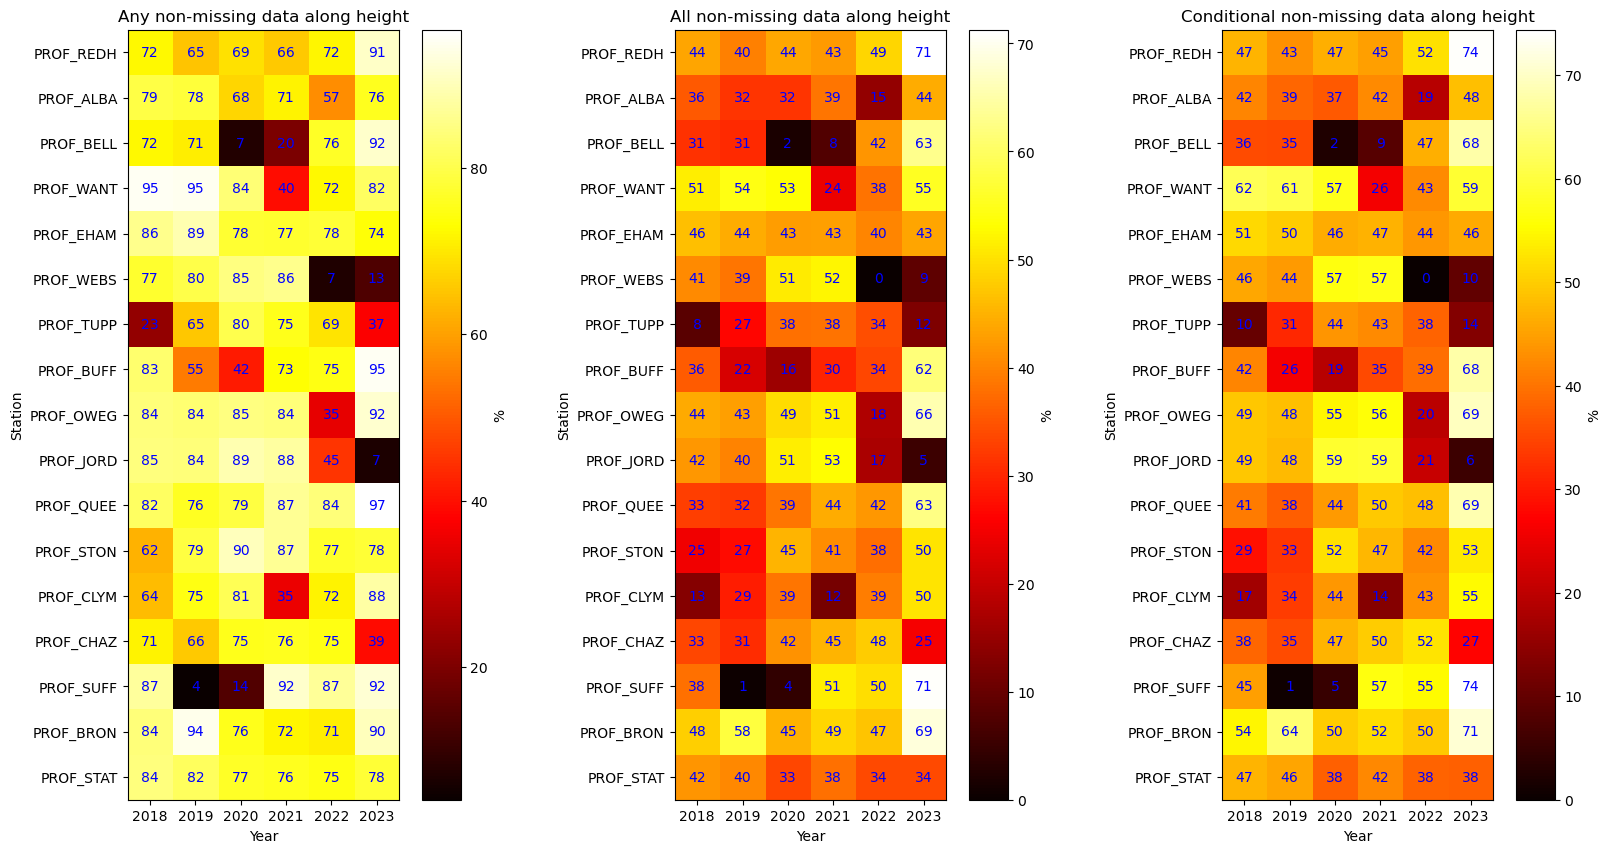

In [30]:
# now, plot a heatmap of the dataframe to visualize the missing data
plt.figure(figsize=(20,10))

# --- all missing data
plt.subplot(1,3,1)
plt.imshow(df_all, cmap='hot', interpolation='nearest')
# show values
for i in range(len(df_all.index)):
    for j in range(len(df_all.columns)):
        plt.text(j, i, round(df_all.values[i, j]), ha='center', va='center', color='blue')
plt.colorbar(label='%')
plt.title('Any non-missing data along height')
plt.xlabel('Year')
plt.ylabel('Station')
# set the x-axis labels to be the years and the y-axis labels to be the station numbers
plt.xticks(range(len(df_all.columns)), df_all.columns)
plt.yticks(range(len(df_all.index)), df_all.index)

# --- any missing data
plt.subplot(1,3,2)
plt.imshow(df_any, cmap='hot', interpolation='nearest')
# show values
for i in range(len(df_any.index)):
    for j in range(len(df_any.columns)):
        plt.text(j, i, round(df_any.values[i, j]), ha='center', va='center', color='blue')
plt.colorbar(label='%')
plt.title('All non-missing data along height')
plt.xlabel('Year')
plt.ylabel('Station')
# set the x-axis labels to be the years and the y-axis labels to be the station numbers
plt.xticks(range(len(df_any.columns)), df_any.columns)
plt.yticks(range(len(df_any.index)), df_any.index)

# --- conditional missing data
plt.subplot(1,3,3)
plt.imshow(df_conditioned, cmap='hot', interpolation='nearest')
# show values
for i in range(len(df_conditioned.index)):
    for j in range(len(df_conditioned.columns)):
        plt.text(j, i, round(df_conditioned.values[i, j]), ha='center', va='center', color='blue')
plt.colorbar(label='%')
plt.title('Conditional non-missing data along height')
plt.xlabel('Year')
plt.ylabel('Station')
# set the x-axis labels to be the years and the y-axis labels to be the station numbers
plt.xticks(range(len(df_conditioned.columns)), df_conditioned.columns)
plt.yticks(range(len(df_conditioned.index)), df_conditioned.index)

plt.show()

# Plotting New York state, with ERA5 land-sea mask superimposed by the NYSM profiler locations

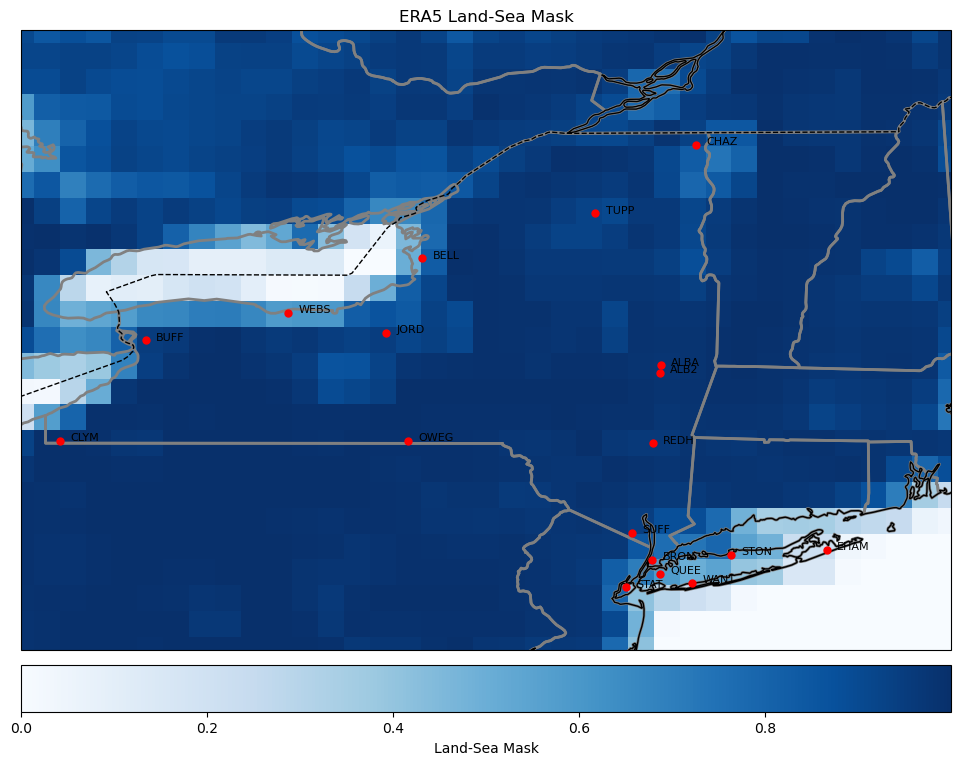

In [77]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the land-sea mask dataset
ds = xr.open_dataset('data/ERA5_lsm.nc').lsm.isel(valid_time=0)

# Convert longitudes from 0-360 to -180 to 180
ds = ds.assign_coords(longitude=((ds.longitude + 180) % 360) - 180)

# Select data within the approximate region of New York State
ds_ny = ds.sel(latitude=slice(46, 40), longitude=slice(-80, -71))

# Plot the data
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ds_ny.plot(ax=ax, cmap='Blues', transform=ccrs.PlateCarree(), 
           add_colorbar=True, cbar_kwargs={'label': 'Land-Sea Mask', 'orientation': 'horizontal', 'pad': 0.02})

# Add state boundaries and focus on New York State
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=2)
ax.set_extent([-80, -71, 40, 46], crs=ccrs.PlateCarree())

# Add coastlines for reference
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='--')

# Set title and remove gridlines
plt.title("ERA5 Land-Sea Mask")

profiler_stations = pd.read_csv('data/profiler_locations.csv',usecols=[0,3,4])
# Loop over the profiler stations and plot them
for index, row in profiler_stations.iterrows():
    lon = row['lon [degrees]']
    lat = row['lat [degrees]']
    station_id = row['stid'][5:]
    
    # Plot the station as a red dot
    ax.plot(lon, lat, marker='o', color='red', markersize=5, transform=ccrs.PlateCarree())
    
    # Label the station with its ID
    ax.text(lon + 0.1, lat, station_id, color='black', fontsize=8, transform=ccrs.PlateCarree())


plt.show()

- Lets go with OWEG.

# Combining 10m wind speed from NYSM standard 5 min data into profiler 10 min data

## Read 10 m wind speed from NYSM standard 5 min data
- Since the dataset a temporal resolution of every 5 minutes, lets average 55th, 0th, and 5th times, centered at 0th. 

In [3]:
station = 'OWEG'
ds = xr.open_dataset(f'data/request/{station}.nc').avg_wind_speed_merge

# Select data points at the 5th, 0th, and 55th minute
data_at_55th_min = ds.sel(time=ds.time.dt.minute == 55)
data_at_0th_min = ds.sel(time=ds.time.dt.minute == 0)
data_at_5th_min = ds.sel(time=ds.time.dt.minute == 5)


# Shift 5th minute data to align with the previous hour's 0th minute
data_at_5th_min['time'] = data_at_5th_min.time - pd.Timedelta(minutes=5)
# Shift 55th minute data to align with the next hour's 0th minute
data_at_55th_min['time'] = data_at_55th_min.time + pd.Timedelta(minutes=5)

# Combine the two, averaging where both exist
stacked_data = xr.concat([data_at_55th_min,data_at_0th_min,data_at_5th_min], dim='new') 
hourly_data_10m = xr.apply_ufunc(np.nanmean, stacked_data, input_core_dims=[['new']], kwargs={'axis': -1})
hourly_data_10m

/opt/miniconda3/envs/TabNet_env/lib/python3.12/site-packages/xarray/core/computation.py:831: RuntimeWarning: Mean of empty slice
  result_data = func(*input_data)


<xarray.DataArray 'avg_wind_speed_merge' (time: 59305)> Size: 237kB
array([4.341073 , 4.0867085, 4.674709 , ..., 1.5970521, 0.8156702,
       0.       ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 474kB 2018-01-02 ... 2024-10-08

## Read profiler levels beyond 100 m, at 10 min data
- Make them into 1 hour by averaging 55min and 5 min data
- Remember, units are in knots (only for velocity. The horizontal (u,v) and vertical (w) wind speeds are in m/s, in other files)
- Convert knots into m/s

In [6]:
year = 2018
file = sorted(glob.glob(f'data/{year}_velocity.nc'))[0]
ds = xr.open_dataset(file).velocity
# convert knots to m/s
ds = ds * 0.514444

# Select data points at the 5th and 55th minute
data_at_5th_min = ds.sel(time=ds.time.dt.minute == 5).sel(range=slice(100, 1000)).sel(station=f'PROF_{station}')
data_at_55th_min = ds.sel(time=ds.time.dt.minute == 55).sel(range=slice(100, 1000)).sel(station=f'PROF_{station}')

# Shift 5th minute data to align with the previous hour's 0th minute
data_at_5th_min['time'] = data_at_5th_min.time - pd.Timedelta(minutes=5)
# Shift 55th minute data to align with the next hour's 0th minute
data_at_55th_min['time'] = data_at_55th_min.time + pd.Timedelta(minutes=5)

# Combine the two, averaging where both exist
stacked_data = xr.concat([data_at_5th_min, data_at_55th_min], dim='new') 
hourly_data_100m_beyond = xr.apply_ufunc(np.nanmean, stacked_data, input_core_dims=[['new']], kwargs={'axis': -1})

/opt/miniconda3/envs/TabNet_env/lib/python3.12/site-packages/xarray/core/computation.py:831: RuntimeWarning: Mean of empty slice
  result_data = func(*input_data)


In [19]:
# Select only the common time indices
common_time = hourly_data_10m['time'].where(hourly_data_10m['time'].isin(hourly_data_100m_beyond['time']), drop=True)

# Filter both datasets to keep only the common times
hourly_data_10m_common = hourly_data_10m.sel(time=common_time)
hourly_data_100m_beyond_common = hourly_data_100m_beyond.sel(time=common_time)

# Create a new dimension called 'range' for the 10m data
hourly_data_10m_common = hourly_data_10m_common.expand_dims(dim={'range': 1})
hourly_data_10m_common = hourly_data_10m_common.assign_coords(range=[10])  # Assigning the range value of 10

# Concatenate the two datasets along the 'range' dimension
combined_data = xr.concat([hourly_data_10m_common,hourly_data_100m_beyond_common], dim='range')
combined_data

<xarray.DataArray 'avg_wind_speed_merge' (range: 38, time: 8737)> Size: 1MB
array([[ 4.341073 ,  4.0867085,  4.674709 , ...,  6.7654476,  6.4912553,
         6.023947 ],
       [       nan,        nan,        nan, ..., 21.737465 , 19.753618 ,
        21.075567 ],
       [       nan,        nan,        nan, ..., 23.889324 , 22.319399 ,
        24.271326 ],
       ...,
       [       nan,        nan,        nan, ..., 35.932602 , 48.567703 ,
               nan],
       [       nan,        nan,        nan, ..., 35.08374  , 48.630005 ,
               nan],
       [       nan,        nan,        nan, ..., 34.66311  , 47.98083  ,
               nan]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 70kB 2018-01-02 ... 2019-01-01
  * range    (range) int64 304B 10 100 125 150 175 200 ... 900 925 950 975 1000
    station  <U9 36B 'PROF_OWEG'